# Install libraries and imports

In [1]:
# !pip install tensorflow
# !pip install yfinance --upgrade --no-cache-dir

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import math
from sklearn.metrics import mean_squared_error
import yfinance as yf

2024-06-19 12:27:28.476955: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 12:27:28.479394: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 12:27:28.512148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 12:27:29.179774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Get data form yahoo

In [3]:
msft = yf.Ticker("NVDA")

# get historical market data
hist = msft.history(period="max")

In [4]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.040129,0.044786,0.035590,0.037621,2714688000,0.0,0.0
1999-01-25 00:00:00-05:00,0.040607,0.042039,0.037621,0.041562,510480000,0.0,0.0
1999-01-26 00:00:00-05:00,0.042039,0.042876,0.037740,0.038337,343200000,0.0,0.0
1999-01-27 00:00:00-05:00,0.038457,0.039412,0.036307,0.038218,244368000,0.0,0.0
1999-01-28 00:00:00-05:00,0.038218,0.038457,0.037859,0.038098,227520000,0.0,0.0


# Data Analysis - Plots

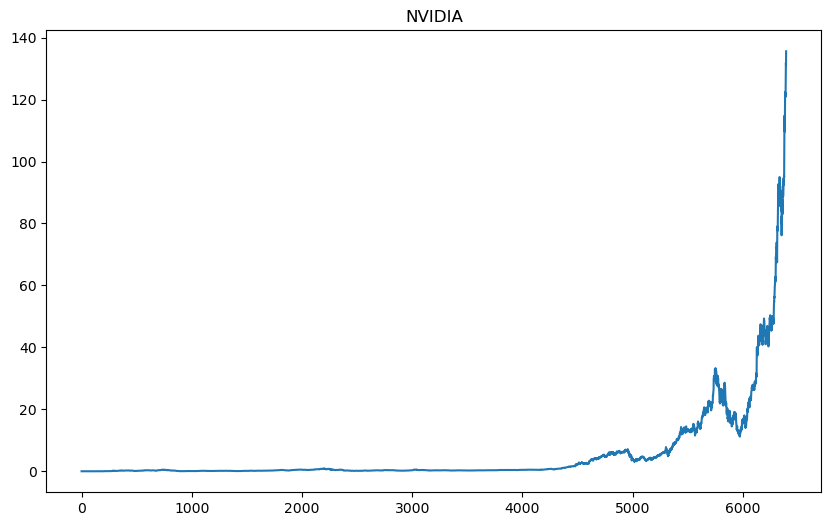

In [5]:
df2 = hist.reset_index()['Close']

plt.figure(figsize=(10, 6))
plt.plot(df2)
plt.title("NVIDIA")
plt.show()

# Data Preprocessing

In [6]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(6393, 1)

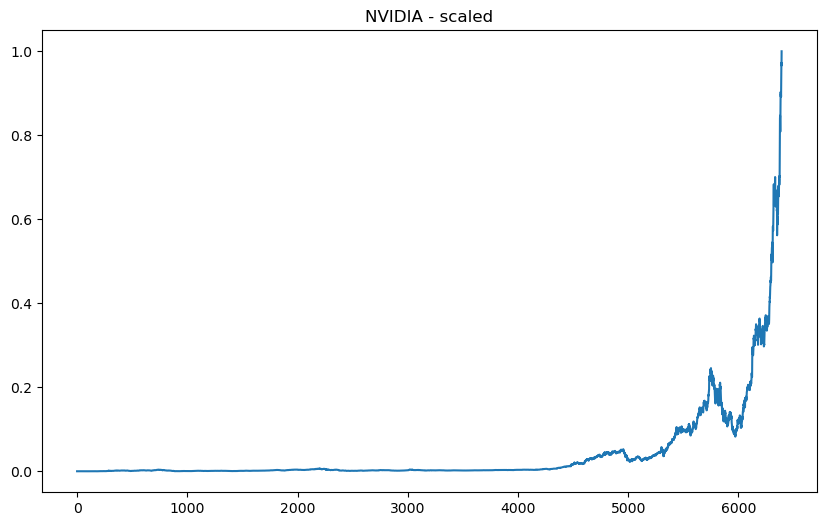

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df2)
plt.title("NVIDIA - scaled")
plt.show()

## Train-Test split

In [8]:
train_size = int(len(df2)*0.65)
test_size = len(df2) - train_size
train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1]

A function is created as create_dataset() which splits the dataset into 2 based on the time step we take. The first dataset i.e.; dataX takes the values as its input and the second dataset dataY takes the values as output. Basically it creates a dataset matrix from the above dataset.

In [9]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0] # TODO: dont add the second column here just reshape later
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

`time_step` is described by the amount of data of days given for 1 prediction. (For example by setting `time_step`=100, we give the model 100 days of data to predict the 101 day)

In [10]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100 
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [11]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(4054, 100)
[[4.66973909e-05 7.57742797e-05 5.19823516e-05 ... 1.85003166e-05
  8.81029230e-06 8.81029230e-06]
 [7.57742797e-05 5.19823516e-05 5.11025096e-05 ... 8.81029230e-06
  8.81029230e-06 1.58544422e-05]
 [5.19823516e-05 5.11025096e-05 5.02161542e-05 ... 8.81029230e-06
  1.58544422e-05 8.81029230e-06]
 ...
 [3.78688941e-03 3.71222262e-03 3.75666643e-03 ... 3.28754923e-03
  3.30362351e-03 3.23575623e-03]
 [3.71222262e-03 3.75666643e-03 3.83311017e-03 ... 3.30362351e-03
  3.23575623e-03 3.27861922e-03]
 [3.75666643e-03 3.83311017e-03 3.77800074e-03 ... 3.23575623e-03
  3.27861922e-03 3.23754219e-03]]
(2137, 100)
(2137,)


# Create Model

In [12]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

2024-06-19 12:27:30.918511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-19 12:27:30.921956: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/thanos/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 10)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


## Plotting the results

Lookback variable takes the number of values behind the current value i.e.; remembering the previous 100 values which is as same as LSTM. Here every time while plotting the graph, the trainPredictionPlot will take 100 values behind them and plot it. and the plotting goes from previous 100th value and goes till the length of the trainpredict + the lookback i.e.; 100.

In [16]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

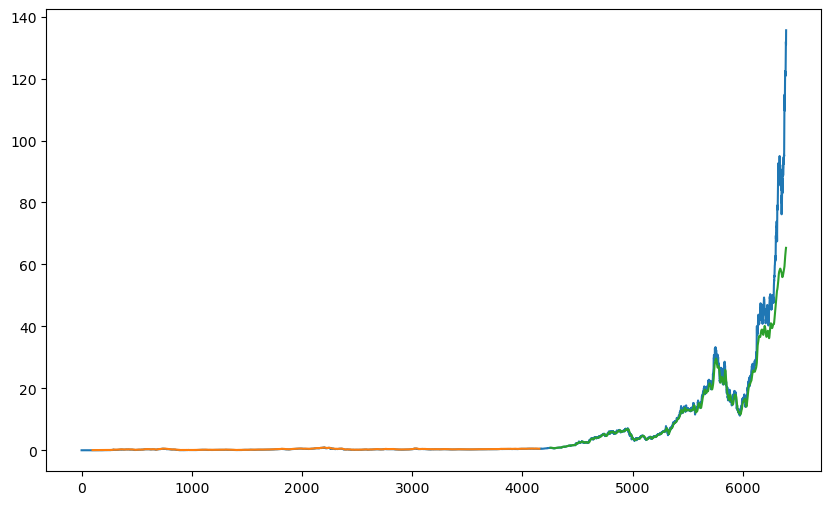

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
# plt.legend()
plt.show()

# BI-LSTM approach

In [18]:
model = Sequential()
# Adding Bidirectional LSTM layers
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
# Adding Dense layer
model.add(Dense(1))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

/home/thanos/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100, 100)       │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 100)       │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,701 (553.52 KB)

 Trainable params: 141,701 (553.52 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 8.0941e-05 - val_loss: 0.0359
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 1.3573e-06 - val_loss: 0.0334
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 1.1931e-06 - val_loss: 0.0299
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 1.0179e-06 - val_loss: 0.0252
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 8.6691e-07 - val_loss: 0.0177
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 5.6423e-07 - val_loss: 0.0075
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 2.0720e-07 - val_loss: 0.0034
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 1.5454e-07 - val_loss: 0.0034
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 1.1449e-07 - val_loss: 0.0036
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 1.6334e-07 - val_loss: 0.0034
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 1.7462e-07 - val_loss: 0.0033
Epoch 1

In [21]:
train_predict2 = model.predict(X_train)
test_predict2 = model.predict(X_test)

# transform to original form
train_predict2 = scaler.inverse_transform(train_predict2)
test_predict2 = scaler.inverse_transform(test_predict2)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [22]:
look_back = 100

trainPredictPlot2 = np.empty_like(df2)
trainPredictPlot2[:,:] = np.nan
trainPredictPlot2[look_back : len(train_predict2)+look_back,:] = train_predict2

testPredictPlot2 = np.empty_like(df2)
testPredictPlot2[:,:] = np.nan
testPredictPlot2[len(train_predict2)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict2

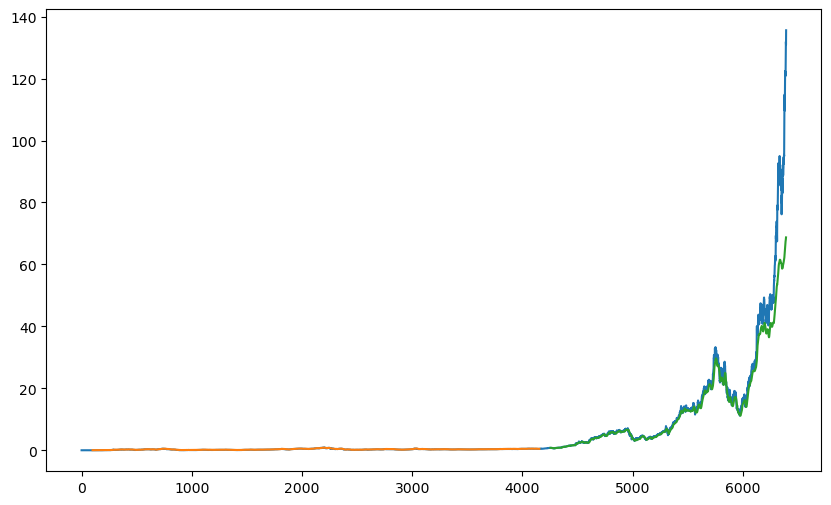

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot2)
plt.plot(testPredictPlot2)
# plt.legend()
plt.show()

# Keeping LSTM at Epoch 30 for now

We are gonna implement a function to predict N days in the future. To achieve that we need to recursively predict 1 day ahead then put that day in the data and continue to the next iteration.

In [24]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

/home/thanos/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 30,batch_size = 64,verbose = 10)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


In [26]:
def predict_days(n_days: int, model, X_data):
    """Predict N days in the future"""
    preds = []
    X = X_data[-1:, :] # Keep the last sample (the last 100 days)
    for day in range(n_days):
        prediction = model.predict(X, verbose=-1)
        preds.append(prediction[0][0])
        X = np.concatenate((X[:, 1:], prediction.reshape(1, -1)), axis=1) # replace the last element with the prediction (thus moving a day forward)
        
    # preds = scaler.inverse_transform(preds)
    
    return preds
    
    

In [27]:
preds = predict_days(100, model, X_test)

In [31]:
preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [38]:
look_back = 100

trainPredictPlot2 = np.empty_like(df2)
trainPredictPlot2[:,:] = np.nan
trainPredictPlot2[look_back : len(train_predict2)+look_back,:] = train_predict2

testPredictPlot2 = np.empty_like(df2)
testPredictPlot2[:,:] = np.nan
testPredictPlot2[len(train_predict2)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict2

# Extend the shape to accommodate future predictions
futurePredictPlot = np.empty((len(df2) + 100, 1))
futurePredictPlot[:] = np.nan

# Assign the predictions to the correct position in the extended array
futurePredictPlot[len(df2):] = preds

# Adjust the combined plotting logic
combined_plot = np.empty_like(futurePredictPlot)
combined_plot[:] = np.nan
combined_plot[:len(trainPredictPlot2)] = trainPredictPlot2
combined_plot[:len(testPredictPlot2)] = testPredictPlot2


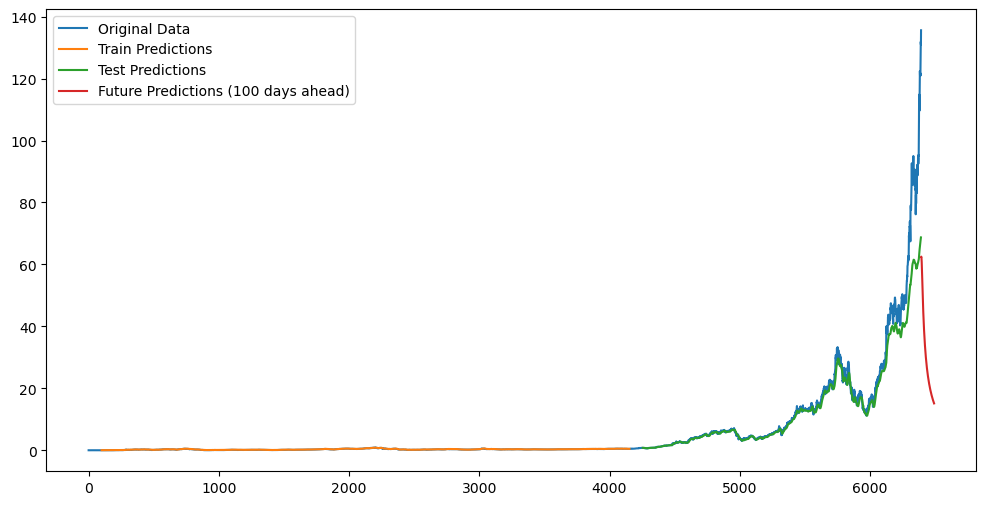

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df2), label='Original Data')
plt.plot(trainPredictPlot2, label='Train Predictions')
plt.plot(testPredictPlot2, label='Test Predictions')
plt.plot(futurePredictPlot, label='Future Predictions (100 days ahead)')
plt.legend()
plt.show()